In [1]:
import os
import sys
import torch
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
from src.models.CVAE import CVAELitModule

model = CVAELitModule.load_from_checkpoint(
    r"D:\felix-ml\logs\train\runs\2023-08-02_22-20-37\checkpoints\epoch_049.ckpt")

data_dir = "../data/FDP/"

In [8]:
sample_size = 16

ICSD_codes = os.listdir(data_dir)
chosen_codes = np.random.choice(ICSD_codes, sample_size)

In [9]:
latent_dims = model.latent_dims

structures = np.concatenate([
    np.load(os.path.join(data_dir, ICSD_code, ICSD_code + "_structure.npy")
    ) for ICSD_code in chosen_codes], axis=0)
patterns = np.concatenate([np.clip(
    np.load(os.path.join(data_dir, ICSD_code, ICSD_code + "_+0+0+0.npy")
    ), 0.0, 1.0) for ICSD_code in chosen_codes], axis=0)

structure_tensor = torch.from_numpy(structures).float().clone().detach().view(sample_size, 1, 128, 128).cuda()
pattern_tensor = torch.from_numpy(patterns).float().clone().detach().view(sample_size, 1, 128, 128).cuda()

z = model.encoder(structure_tensor)[0]
fake = model.decoder(z)
predictions_p = fake.view(sample_size * 128, 128).detach().cpu().numpy()

patterns = patterns - np.min(patterns)
patterns = patterns * (1 / np.max(patterns))
predictions_p = predictions_p - np.min(predictions_p)
predictions_p = predictions_p * (1 / np.max(predictions_p))

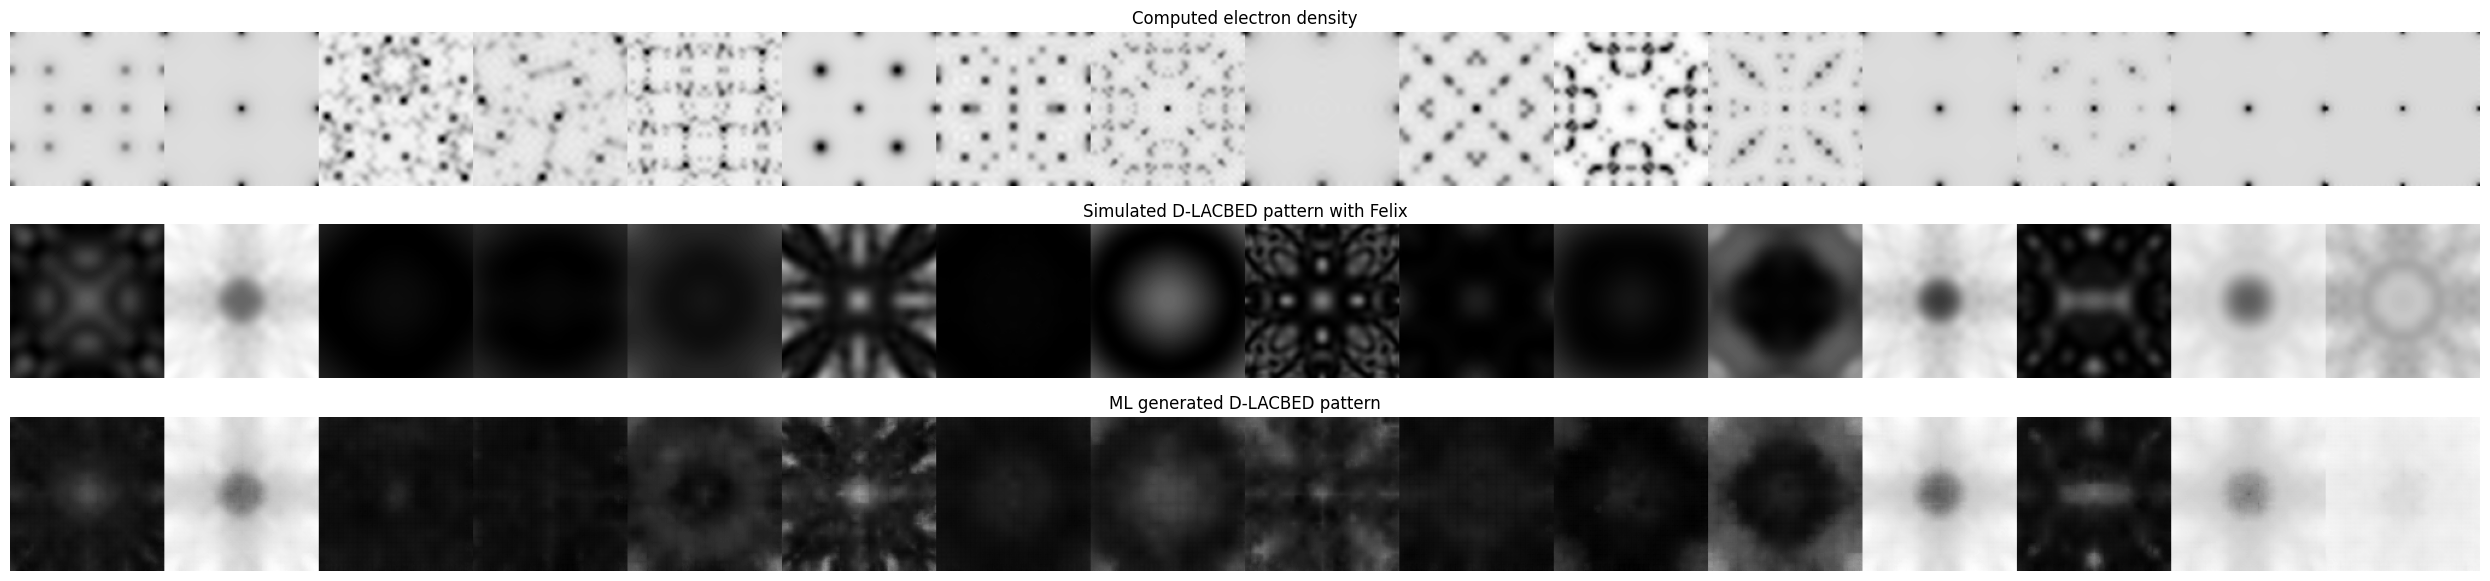

In [11]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(25, 6))

im0 = ax0.imshow(structures.T, cmap="Greys")
ax0.set_title("Computed electron density")

im1 = ax1.imshow(patterns.T, cmap="gray")
ax1.set_title("Simulated D-LACBED pattern with Felix")

im2 = ax2.imshow(predictions_p.T, cmap="gray")
ax2.set_title("ML generated D-LACBED pattern")

for ax in (ax0, ax1, ax2):
    ax.axis('off')
plt.tight_layout()
plt.show()